In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.special
from scipy.interpolate import interp1d
from functools import cache
from IPython import display
import pandas as pd

import matplotlib

%matplotlib inline

matplotlib.rcParams['font.size'] = 20
matplotlib.rcParams['figure.figsize'] = (14,9)
matplotlib.rcParams['savefig.bbox'] = 'tight'

import multi_distr
from wish_distr import e5s_pdf, e4s_pdf, w5s_pdf, w4s_pdf
import markov

In [2]:
def uc2phw(u, c):
    hits = np.zeros(np.amax(u) + 1)
    hits[u] = c / sum(c)
    
    phw = hits / np.cumsum(hits[::-1])[::-1]
    return phw

In [423]:
df1 = pd.read_csv('chinese_data/Char_pulls_chinese.csv')
df2 = pd.read_csv('whale_pulls_kqm_data/whale_pulls_chars.csv')

In [3]:
df1 = pd.read_csv('chinese_data/Weapons_pulls_chinese.csv')
df2 = pd.read_csv('whale_pulls_kqm_data/whale_pulls_weapons.csv')

In [495]:
whale_pity = {}
hits = []
p = None
for i, r in df1.iterrows():
    wid = r['Wish']  # fucked up cols
    if wid not in whale_pity:
        whale_pity[wid] = 0
    
    whale_pity[wid] += 1
    if r['Rarity'] == 4:
        hits.append( min(whale_pity[wid], 9) )

        whale_pity[wid] = 0
    
    p = r
u4s1, c4s1 = np.unique(hits, return_counts=True)

In [503]:
whale_pity = {}
hits = []
p = None
for i, r in df2.iterrows():
    wid = r['Whale_id']
    if wid not in whale_pity:
        whale_pity[wid] = 0
    
    whale_pity[wid] += 1
    if r['Rarity (Star)'] == 4:
        hits.append( min(whale_pity[wid], 9) )

        whale_pity[wid] = 0
    
    p = r
u4s2, c4s2 = np.unique(hits, return_counts=True)

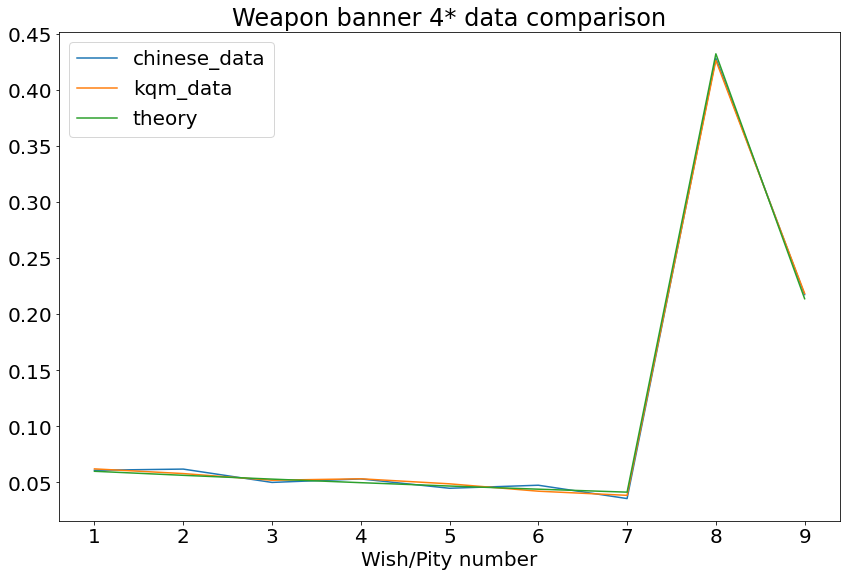

In [508]:
plt.plot(u4s1, c4s1 / sum(c4s1))
plt.plot(u4s2, c4s2 / sum(c4s2))
plt.plot(range(1, 10), [w4s_pdf(z) for z in range(1, 10)])

plt.legend(['chinese_data', 'kqm_data', 'theory'])
plt.title('Weapon banner 4* data comparison')
plt.xlabel('Wish/Pity number')
# plt.savefig('w4s_cmp.png')

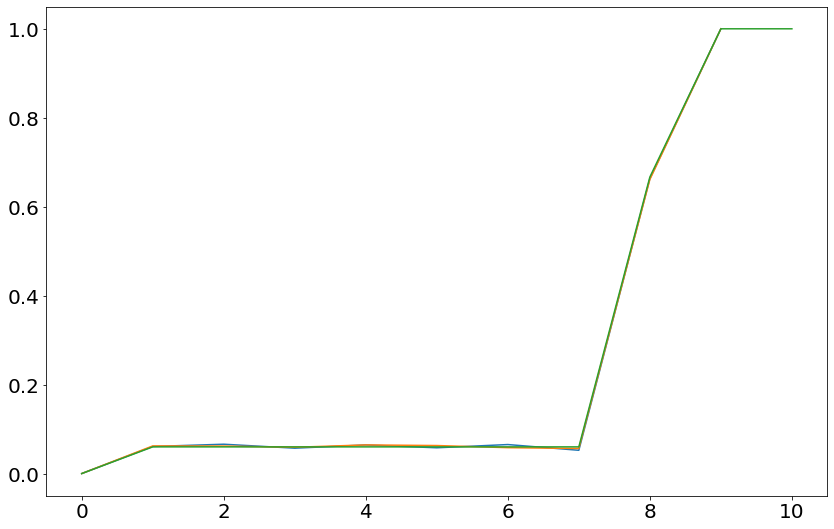

In [513]:
@np.vectorize
def e4_phw(w):
    if 1 <= w <= 8:
        return .051
    elif w == 9:
        return 13/23
    elif w == 10:
        return 1
    return 0.0

@np.vectorize
def w4_phw(w):
    if 1 <= w <= 7:
        return .06
    elif 8 <= w <= 10:
        return [2/3, 1, 1][w-8]
    return 0.0
    
plt.plot(uc2phw(u4s1, c4s1))
plt.plot(uc2phw(u4s2, c4s2))
plt.plot(w4_phw(np.arange(11)))
# plt.xlim(8, 10)
# plt.plot(uc2phw(u4s1, c4s1) - uc2phw(u4s2, c4s2))

In [4]:
# pitys = np.array(df1['Pity'])
pitys = np.array(df1['Whale_id'])  # Mis-label on weapon data
locs = df1['Rarity'] == 5
u, c = np.unique(pitys[locs], return_counts=True)

In [5]:
# pitys2 = np.array(df2['Pity'])
pitys2 = np.array(df2['Pity Count'])
# locs2 = df2['Rarity'] == 5
locs2 = df2['Rarity (Star)'] == 5
u2, c2 = np.unique(pitys2[locs2], return_counts=True)

In [6]:
e5s_mult = multi_distr.MultiDistr(e5s_pdf, n_max=90)
w5s_mult = multi_distr.MultiDistr(w5s_pdf, n_max=90)

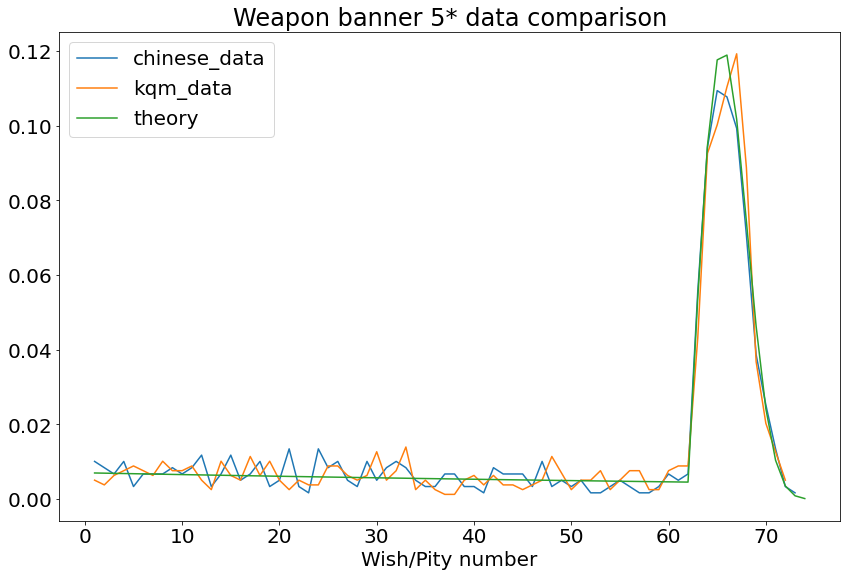

In [9]:
plt.plot(u, c / np.sum(c))
plt.plot(u2, c2 / np.sum(c2))
plt.plot(np.arange(1, 75), w5s_mult(np.arange(1, 75)))
plt.legend(['chinese_data', 'kqm_data', 'theory'])

plt.title('Weapon banner 5* data comparison')
plt.xlabel('Wish/Pity number')
# plt.savefig('w5s_cmp.png')

In [384]:
@np.vectorize
def w5_phw(w):
    if 1 <= w <= 62:
        return .007
    elif 62 <= w <= 75:
        return .007 + (1 - .007) / (75 - 62) * (w - 62)
    elif 75 < w:
        return 1
    return 0.0

@np.vectorize
def e5_phw(w):
    if 1 <= w <= 73:
        return .006
    elif 73 <= w <= 89:
        return .006 + (1-.006)/(89 - 73) * (w-73)
    else:
        return 0.0

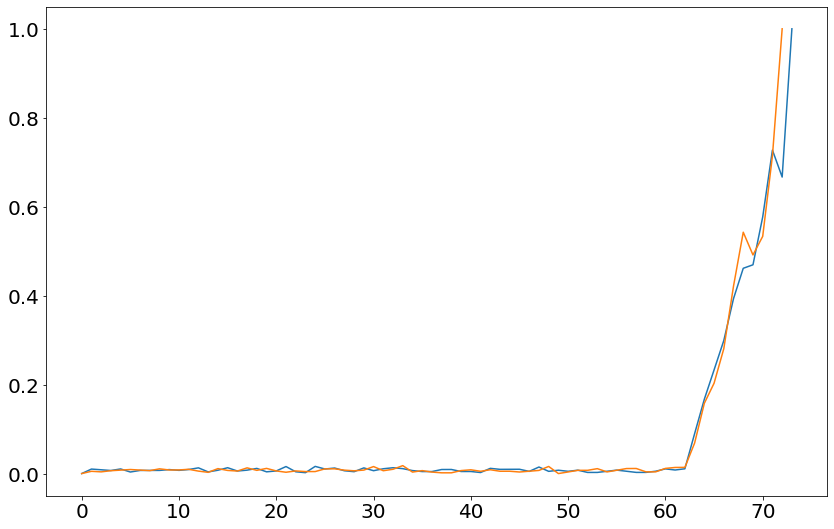

In [518]:
plt.plot(uc2phw(u, c))
plt.plot(uc2phw(u2, c2))

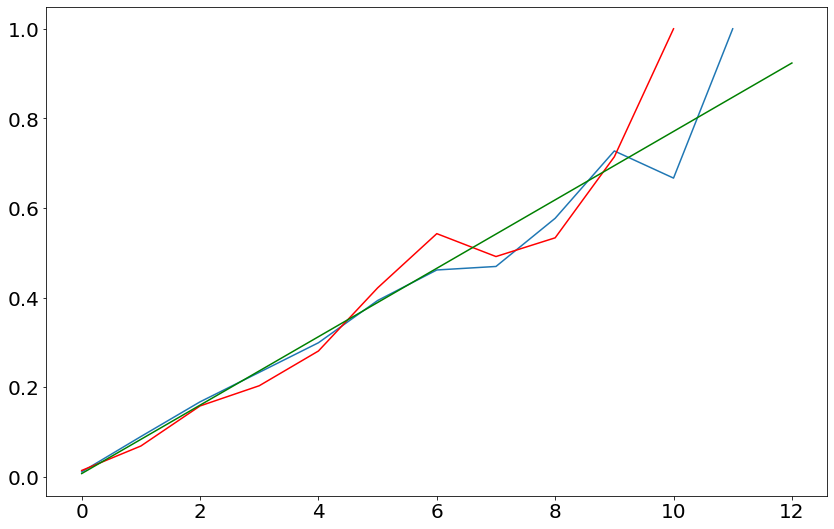

In [519]:
slc = slice(62, 75)

plt.plot(uc2phw(u, c)[slc])
# plt.plot(np.clip((b + sb)[slc], 0, 1), color='orange')
# plt.plot(np.clip((b - sb)[slc], 0, 1), color='orange')

plt.plot(uc2phw(u2, c2)[slc], color='red')

bbz = w5_phw(np.arange(90))[slc]
plt.plot(bbz, color='g')

# zzz = w5s_mult(np.arange(0, 90))
# plt.plot(np.clip(zzz / (np.cumsum(zzz[::-1])[::-1]), 0, 1)[slc])
# plt.plot(dd2)